STAT 453: Deep Learning (Spring 2020)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2020/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss20

---

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.7.1
IPython 7.12.0

torch 1.4.0


# MLP With Different Loss Functions

## Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
%matplotlib inline

In [3]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

## Settings and Dataset

In [4]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 1
BATCH_SIZE = 100
NUM_EPOCHS = 100
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([100, 1, 28, 28])
Image label dimensions: torch.Size([100])


In [5]:
def to_onehot(y, num_classes):
    y_onehot = torch.FloatTensor(y.size(0), num_classes)
    y_onehot.zero_()
    tmp = y.view(-1, 1).long().to(torch.device('cpu'))
    y_onehot.scatter_(1, tmp, 1).float()
    return y_onehot

## Model

In [6]:
class MlpSigmoidMSE(torch.nn.Module):

    def __init__(self, num_features, num_hidden, num_classes):
        super(MlpSigmoidMSE, self).__init__()
        
        self.num_classes = num_classes
        
        ### 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_features, num_hidden)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()

        ### Output layer
        self.linear_out = torch.nn.Linear(num_hidden, num_classes)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()
        
    def forward(self, x):
        out = self.linear_1(x)
        out = torch.sigmoid(out)
        logits = self.linear_out(out)
        probas = torch.softmax(logits, dim=1)
        return logits, probas

    
#################################
### Model Initialization
#################################
    
torch.manual_seed(RANDOM_SEED)
model = MlpSigmoidMSE(num_features=28*28,
                      num_hidden=100,
                      num_classes=10)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#################################
### Training
#################################

def compute_loss(net, data_loader):
    curr_loss = 0.
    with torch.no_grad():
        for cnt, (features, targets) in enumerate(data_loader):
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = net.forward(features)
            loss = F.nll_loss(torch.log(probas), targets)
            # or better (more numerically stable):
            # loss = F.cross_entropy(logits, targets)
            # see 
            # ../../other/pytorch-lossfunc-cheatsheet.md
            curr_loss += loss
        return float(curr_loss)/cnt



start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        
        #y_onehot = to_onehot(targets, model.num_classes).to(DEVICE)
        
        cost = F.nll_loss(torch.log(probas), targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))
        
    cost = compute_loss(model, train_loader)
    epoch_cost.append(cost)
    print('Epoch: %03d/%03d Train Cost: %.4f' % (
            epoch+1, NUM_EPOCHS, cost))
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/100 | Batch 000/600 | Cost: 2.3579
Epoch: 001/100 | Batch 050/600 | Cost: 1.8853
Epoch: 001/100 | Batch 100/600 | Cost: 1.4858
Epoch: 001/100 | Batch 150/600 | Cost: 1.0450
Epoch: 001/100 | Batch 200/600 | Cost: 0.9816
Epoch: 001/100 | Batch 250/600 | Cost: 0.8292
Epoch: 001/100 | Batch 300/600 | Cost: 0.7118
Epoch: 001/100 | Batch 350/600 | Cost: 0.6683
Epoch: 001/100 | Batch 400/600 | Cost: 0.4790
Epoch: 001/100 | Batch 450/600 | Cost: 0.6711
Epoch: 001/100 | Batch 500/600 | Cost: 0.4821
Epoch: 001/100 | Batch 550/600 | Cost: 0.5106
Epoch: 001/100 Train Cost: 0.4951
Time elapsed: 0.23 min
Epoch: 002/100 | Batch 000/600 | Cost: 0.5281
Epoch: 002/100 | Batch 050/600 | Cost: 0.3814
Epoch: 002/100 | Batch 100/600 | Cost: 0.5348
Epoch: 002/100 | Batch 150/600 | Cost: 0.3768
Epoch: 002/100 | Batch 200/600 | Cost: 0.3754
Epoch: 002/100 | Batch 250/600 | Cost: 0.4553
Epoch: 002/100 | Batch 300/600 | Cost: 0.4784
Epoch: 002/100 | Batch 350/600 | Cost: 0.2455
Epoch: 002/100 | Batch 

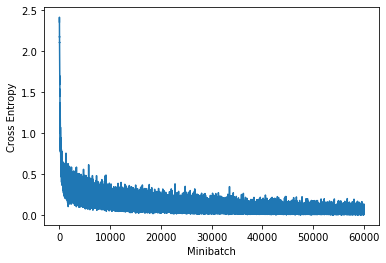

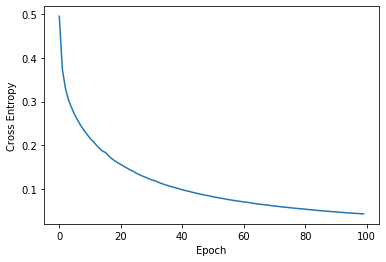

In [7]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [8]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            a1, a2 = net.forward(features)
            predicted_labels = torch.argmax(a2, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100
    
print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Training Accuracy: 99.00
Test Accuracy: 97.67
